In [1]:
import os
import time
import numpy as np
from PIL import Image

from src.controller import ml_controllerV2 as mlc2


################## PATH ##################
LFW_DATASET_PATH = r"..\data\dataset-lfw_reconstructed"
DB_PATH = r"..\data\gui_database.db"
ML_OUTPUT = r"..\data\ml_models"
MODEL_SAVE_DIR = f'{ML_OUTPUT}/trained'
LOG_DIR = f'{ML_OUTPUT}/logs'


############# MODEL SETTINGS #############
#####--- prepare_data_train_model ---#####
INPUT_SHAPE = (100, 100, 1)
IMG_WIDTH, IMG_HEIGHT, CHANNELS = INPUT_SHAPE
SPLIT_STRATEGY = 'stratified'
TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.15
RANDOM_STATE = 42
N_TRAIN_PER_SUBJECT = 7
#####--- create_model ---#####
MODEL_NAME = 'simple_cnn_lfw_anony_v1'
MODEL_ARCHITECTURE = 'simple_cnn'
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10
TRANSFER_BASE_MODEL_NAME = 'MobileNetV2'
TRANSFER_FREEZE_BASE = True
#####--- train_model ---#####
BATCH_SIZE = 32
EPOCHS = 50
##########################################

# Import Data

### Noised DB dataset

In [2]:
X, y, label_encoder = mlc2.MLController.get_data_from_db(DB_PATH)
print(f"(nb_image, width, height, channels) : {X.shape}")

(nb_image, width, height, channels) : (467, 100, 100, 3)


### Noised LFW dataset

In [3]:
import controller.ml_controller as ml
os.makedirs(LFW_DATASET_PATH, exist_ok=True)

X, y, label_encoder = ml.data_loader.load_anonymized_images_flat(
    data_dir=LFW_DATASET_PATH,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    color_mode='grayscale'
)

if not X.shape and not y.shape and not label_encoder:
    raise ValueError('Critical error while loading data. Script stopped..')
print(f"\n(nb_image, width, height, channels) : {X.shape}")

Chargement des images depuis : ..\data\dataset-lfw_reconstructed
Format attendu : 100x100, mode: grayscale
Trouvé 1240 fichiers PNG.
Chargement terminé. 1240 images traitées, 0 fichiers ignorés.
Shape final des données (X): (1240, 100, 100, 1)
1240 labels originaux encodés en 62 classes numériques.

(nb_image, width, height, channels) : (1240, 100, 100, 1)


# Train

In [4]:
res = mlc2.prepare_data_train_model(
    X, y, label_encoder,
    input_shape=INPUT_SHAPE,
    split_strategy=SPLIT_STRATEGY,
    test_split_ratio=TEST_SPLIT_RATIO,
    validation_split_ratio=VALIDATION_SPLIT_RATIO,
    random_state=RANDOM_STATE,
    n_train_per_subject=N_TRAIN_PER_SUBJECT
)
num_classes, X_train, y_train, X_test, y_test, X_val, y_val, validation_data = res
print(X_train.shape)

Division des données : test_size=0.2, validation_size=0.15
Taille Test: 248 échantillons
Taille Entraînement: 806 échantillons
Taille Validation: 186 échantillons
(806, 150, 150, 1)


In [5]:
res = mlc2.create_model(
    num_classes,
    input_shape=INPUT_SHAPE,
    model_save_dir=MODEL_SAVE_DIR,
    log_dir=LOG_DIR,
    model_name=MODEL_NAME,
    model_architecture=MODEL_ARCHITECTURE,
    learning_rate=LEARNING_RATE,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    transfer_base_model_name=TRANSFER_BASE_MODEL_NAME,
    transfer_freeze_base=TRANSFER_FREEZE_BASE
)
model, callbacks, model_filepath, summary_text = res

Construction du modèle CNN simple avec input_shape=(150, 150, 1) et num_classes=62
Modèle CNN simple construit.


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense1 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,289,246 (43.07 MB)

 Trainable params: 11,288,606 (43.06 MB)

 Non-trainable params: 640 (2.50 KB)

--- Starting the Training Script ---

Epoch 1: val_accuracy improved from -inf to 0.01613, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 2: val_accuracy did not improve from 0.01613

Epoch 3: val_accuracy did not improve from 0.01613

Epoch 4: val_accuracy improved from 0.01613 to 0.02151, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 5: val_accuracy improved from 0.02151 to 0.02688, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 6: val_accuracy improved from 0.02688 to 0.05376, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 7: val_accuracy did not improve from 0.05376

Epoch 8: val_accuracy did not improve from 0.05376

Epoch 9: val_accuracy did not improve from 0.05376

Epoch 10: val_accuracy did not improve from 0.05376

Epoch 11: val_accuracy improved from 0.05376 to 0.05914, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 12: val_accuracy improved from 0.05914 to 0.06452, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 13: val_accuracy improved from 0.06452 to 0.15591, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 14: val_accuracy did not improve from 0.15591

Epoch 15: val_accuracy improved from 0.15591 to 0.46237, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 16: val_accuracy did not improve from 0.46237

Epoch 17: val_accuracy improved from 0.46237 to 0.66129, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 18: val_accuracy improved from 0.66129 to 0.79570, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 19: val_accuracy improved from 0.79570 to 0.92473, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 20: val_accuracy improved from 0.92473 to 0.93548, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 21: val_accuracy improved from 0.93548 to 0.96237, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 22: val_accuracy improved from 0.96237 to 0.96774, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 23: val_accuracy improved from 0.96774 to 0.97312, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 24: val_accuracy improved from 0.97312 to 0.98387, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 25: val_accuracy improved from 0.98387 to 0.98925, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 26: val_accuracy did not improve from 0.98925

Epoch 27: val_accuracy did not improve from 0.98925

Epoch 28: val_accuracy did not improve from 0.98925

Epoch 29: val_accuracy improved from 0.98925 to 0.99462, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 30: val_accuracy did not improve from 0.99462

Epoch 31: val_accuracy did not improve from 0.99462

Epoch 32: val_accuracy did not improve from 0.99462

Epoch 33: val_accuracy did not improve from 0.99462

Epoch 34: val_accuracy did not improve from 0.99462

Epoch 35: val_accuracy did not improve from 0.99462

Epoch 36: val_accuracy did not improve from 0.99462

Epoch 37: val_accuracy did not improve from 0.99462

Epoch 38: val_accuracy did not improve from 0.99462

Epoch 39: val_accuracy did not improve from 0.99462
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 29.
LabelEncoder sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9889 - loss: 0.1476
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step

curves : <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1200x500 at 0x1C06174B800>

confusion_matrix : [[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...


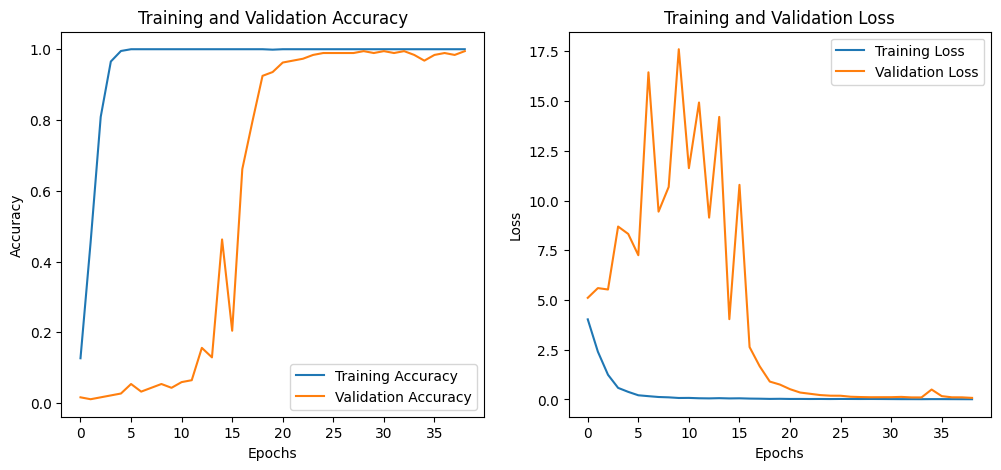

In [6]:
# Start timer
print("--- Starting the Training Script ---")
start_time = time.time()

# Train Model
res = mlc2.train_model(
    model,
    X_train, y_train, X_test, y_test,
    validation_data, callbacks, label_encoder, model_filepath,
    model_save_dir=MODEL_SAVE_DIR,
    model_name=MODEL_NAME,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

)
for key, val in res.items(): print(f"\n{key} : {val}")

# End timer
end_time = time.time()
duration = end_time - start_time
print(f"--- Training Script Completed in {duration:.2f} secondes ---")

# Predict noised image

In [11]:
user = 27
image_path = f"../data/dataset-lfw_reconstructed/reconstructed_{user}_2.png"
image = np.array(Image.open(image_path))

result = mlc2.predict_image(image, MODEL_SAVE_DIR, MODEL_NAME, INPUT_SHAPE)
predicted_label, prediction_confidence = result
print(f"  - Predicted Identity (Subject ID) : {predicted_label}")
print(f"  - Trust : {prediction_confidence:.4f} ({prediction_confidence*100:.2f}%)")

LabelEncoder chargé depuis : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib
Preprocessed image, final shape: (1, 150, 150, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
  - Predicted Identity (Subject ID) : 27
  - Trust : 0.9924 (99.24%)


D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 150, 150, 1, 1))
  warnings.warn(msg)
